In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import os
import matplotlib.pyplot as plt
import IPython.display as idp
import librosa
import librosa.display as ldp

import numpy as np
from glob import glob
import torchvision.transforms as transforms

In [2]:
root = '/kaggle/input/cats-vs-dogs-vs-birds-audio-classification/Animals'

['dog', 'bird', 'cat']
[210, 193, 207]


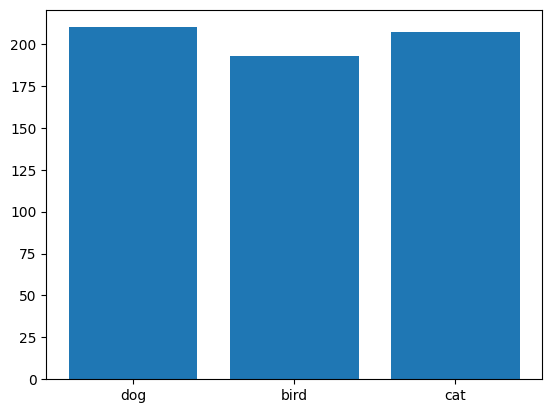

In [3]:
labels = os.listdir(root)
print(labels)

size_of_class = [] 
for label in labels:
    size_of_class.append(len(os.listdir(os.path.join(root,label))))
print(size_of_class)

plt.bar(labels, size_of_class)
plt.show()

In [4]:
class DataReading(Dataset):
    def __init__(self, root):
        self.root = root
        self.labels = os.listdir(root)
        self.data = glob(self.root+'/*/*.wav')
        
        
    def __len__(self):
        return len(self.data)
    
    
    def __getitem__(self, idx):
        return self.preprocess(self.data[idx]), self.get_label(self.data[idx])
    
    
    def preprocess(self, audio_file):
        # load the audio in wave form
        waveform_audio, sample_rate = librosa.load(audio_file)
        
        # Convert image to spectogram short time fourier transform
        waveform_audio_stft = librosa.stft(waveform_audio)
        
        # Convert image to amplitude_db form
        s_db = librosa.amplitude_to_db(np.abs(waveform_audio_stft), ref=np.max )
        
        # Convert to tensor
        s_db = torch.tensor(s_db).unsqueeze(0)
        
        # Resize 
        transform = transforms.Resize((1025,44), antialias=False)
        s_db = transform(s_db)
        
        # Reuturn image form of audio
        return s_db
    def get_label(self, audio_file):
        label = os.path.split(os.path.split(audio_file)[0])[-1]
        return self.labels.index(label)
    

In [5]:
dataset = DataReading(root)


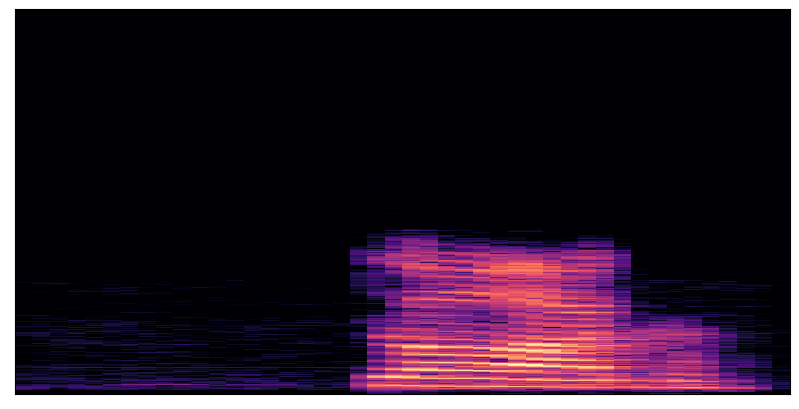

In [7]:
fig, ax = plt.subplots(figsize=(10,5))
ldp.specshow(np.array(dataset[0][0].squeeze()), ax=ax)
plt.show()

# Visulisation of some data

In [79]:
audio_file = os.path.join(root, 'bird',os.listdir(os.path.join(root, 'bird'))[2])

(19757,) 22050


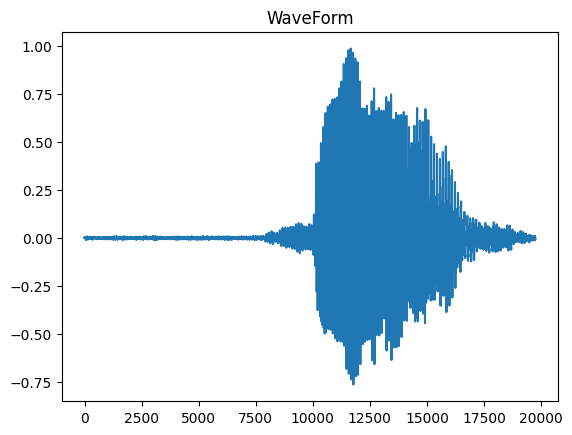

In [84]:
a_f_lib, sr = librosa.load(audio_file)
print(a_f_lib.shape,sr)
plt.plot(a_f_lib)
plt.title('WaveForm')
plt.show()

(1025, 39)


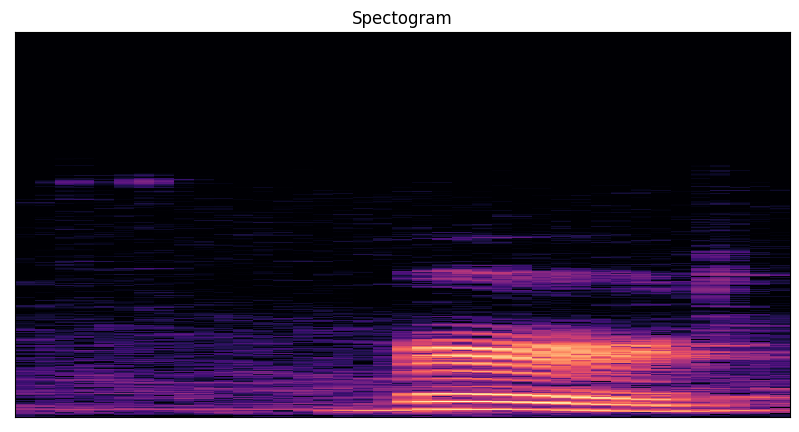

In [85]:
a_f_lib_stft = librosa.stft(a_f_lib)
s_db = librosa.amplitude_to_db(np.abs(a_f_lib_stft), ref=np.max )
print(s_db.shape)
fig, ax = plt.subplots(figsize=(10,5))
ldp.specshow(s_db, ax=ax)
plt.title('Spectogram')
plt.show()

In [172]:
lens = {}
for i in glob('/kaggle/input/cats-vs-dogs-vs-birds-audio-classification/Animals/*/*.wav'):
    audio_file = i
    a_f_lib, sr = librosa.load(audio_file)
    a_f_lib_stft = librosa.stft(a_f_lib)
    s_db = librosa.amplitude_to_db(np.abs(a_f_lib_stft), ref=np.max )
    if s_db.shape in lens:
        lens[s_db.shape]+=1
    else:
        lens[s_db.shape]=0
    

In [173]:
lens

{(1025, 44): 535,
 (1025, 39): 14,
 (1025, 35): 4,
 (1025, 32): 5,
 (1025, 43): 13,
 (1025, 37): 7,
 (1025, 41): 12,
 (1025, 34): 1,
 (1025, 33): 4,
 (1025, 26): 1,
 (1025, 42): 0,
 (1025, 23): 1,
 (1025, 29): 0}

In [185]:
tr = transforms.Resize((1025,44), antialias=False)

In [186]:
sd = tr(torch.tensor(s_db).unsqueeze(0))

torch.Size([1025, 39])


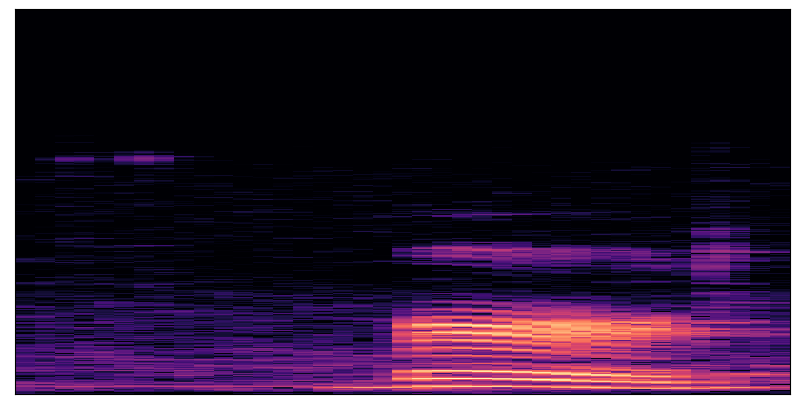

In [184]:
print(sd.squeeze().shape)
fig, ax = plt.subplots(figsize=(10,5))
lpd.specshow(np.array(sd.squeeze()), ax=ax)
plt.show()

# Load the data

In [6]:
dataset_len = len(dataset)
train_size = int(0.8 * dataset_len)
test_size = dataset_len - train_size
train_data, test_data = torch.utils.data.random_split(dataset, [train_size, test_size])

In [7]:
train_loader = DataLoader(train_data, batch_size=16, shuffle=True )
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)

In [8]:
im = next(iter(train_loader))[0][1]

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


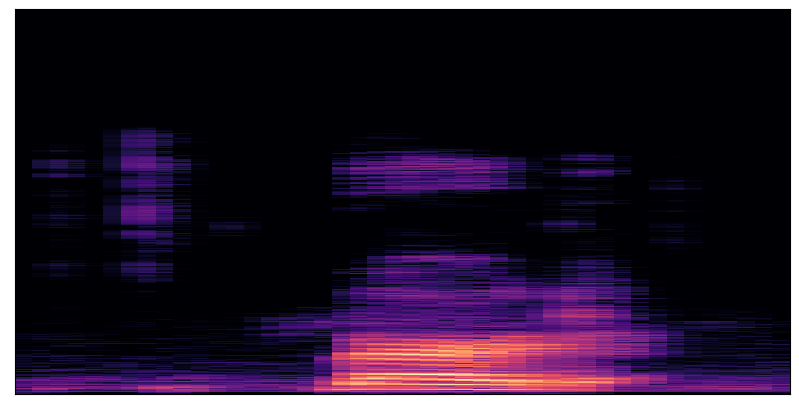

In [9]:
fig, ax = plt.subplots(figsize=(10,5))
ldp.specshow(np.array(im.squeeze()), ax=ax)
plt.show()

# Define Model

In [3]:
# Prooposed DCNN from paper Classification of Apple Disease Based on Non-Linear Deep Features
class DCNN(nn.Module):
    def __init__(self, dropout ):
        super().__init__()
        self.convs = nn.Sequential(
            self._block(1, 128),
            self._block(128, 64),
            self._block(64, 64),
            self._block(64, 32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(2)
        )
        
        self.dense = nn.Sequential(
            nn.Flatten(),
            
            nn.Dropout(p=dropout),
            nn.Linear(in_features=1024, out_features=256),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=256, out_features=3)
        )
    
    def forward(self, x):
        x = self.convs(x)
        return self.dense(x)
        
    def _block(self, in_features, out_features):
        return nn.Sequential(
            nn.Conv2d(in_channels=in_features, out_channels=out_features, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU()
        )
model = DCNN(dropout=0.25)

In [13]:
!pip install torchsummary
from torchsummary import summary
summary(model, (1,1025,44), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 128, 1025, 44]           1,280
         MaxPool2d-2         [-1, 128, 512, 22]               0
              ReLU-3         [-1, 128, 512, 22]               0
            Conv2d-4          [-1, 64, 512, 22]          73,792
         MaxPool2d-5          [-1, 64, 256, 11]               0
              ReLU-6          [-1, 64, 256, 11]               0
            Conv2d-7          [-1, 64, 256, 11]          36,928
         MaxPool2d-8           [-1, 64, 128, 5]               0
              ReLU-9           [-1, 64, 128, 5]               0
           Conv2d-10           [-1, 32, 128, 5]          18,464
        MaxPool2d-11            [-1, 32, 64, 2]               0
             ReLU-12            [-1, 32, 64, 2]               0
           Conv2d-13            [-1, 32, 64, 2]           9,248
        MaxPool2d-14            [-1, 32

# Training

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [10]:
from tqdm.auto import tqdm
def train_step(
    model: torch.nn.Module,
    dataloader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    device:torch.device
):
    # Put model in train mode
    model.train()
    
    # Setup loss and accuracy
    train_loss, train_acc = 0, 0
    
    # Loop throught the data
    for batch, (X, y) in enumerate(tqdm(dataloader)):
        # Send data to device gpu or cpu
        X, y = X.to(device), y.to(device)
        
        # 1. Forward pass
        y_pred = model(X)
        
        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        
        # 3. Optimizer zero grad
        optimizer.zero_grad()
        
        # 4. Loss backward
        loss.backward()
        
        # 5. Optimizer step
        optimizer.step()
        
        # Calculate accuracy across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/ len(y_pred)
        
    train_loss = train_loss/len(dataloader)
    train_acc = train_acc/len(dataloader)
    
    return train_loss, train_acc

In [11]:

#  create test step
def test_step(model: torch.nn.Module,
    dataloader,
    loss_fn: torch.nn.Module,
    device: torch.device
):
    # Put model in eval mode
    model.eval()
    
    # Setup test loss and accuracy
    test_loss, test_acc = 0, 0
    
    # Inference mode or with torch.no_grad()
    with torch.inference_mode():
        # Loop through data
        for batch, (X, y) in enumerate(dataloader):
            # Send code to device
            X , y = X.to(device), y.to(device)
        
            # 1. Forward pass
            test_pred = model.forward(X)
            
            # 2. Calculate loss
            loss = loss_fn(test_pred, y)
            test_loss += loss.item()
            
            # 3. Calculate accuracy
            test_pred_labels = test_pred.argmax(dim=1)
            test_acc += (test_pred_labels == y).sum().item() / len(test_pred_labels)
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [12]:
def train(
    model: torch.nn.Module,
    train_dataloader,
    test_dataloader,
    optimizer: torch.optim.Optimizer,
    loss_fn: torch.nn.Module,
    epochs: int,
    device: torch.device,
    lr_degrade=False
):
    # Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    milestones = [2, 5, 15]  # epochs at which to change the learning rate
    lr_values = [0.01, 0.001, 0.0006]  # learning rates to use after each milestone
    # Loop through data or epochs
    for epoch in range(epochs):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        if lr_degrade:
            if epoch in milestones:
                lr_index = milestones.index(epoch)
                new_lr = lr_values[lr_index]
                for param_group in optimizer.param_groups:
                    param_group['lr'] = new_lr

        
        # Test the model on unseen data
        test_loss, test_acc = test_step(model=model,
                                       dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device
                                       )
        
        
        # Print the loss and accuracy
        print(f"Epoch {epoch+1} ===> ",
              f"Train_loss {train_loss:.4f} ===> ",
              f"Train_acc {train_acc:.4f} ===> ",
              f"Test_loss {test_loss:.4f} ===> ",
              f"Test_acc {test_acc:.4f}"
        )
        
        # update the results
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        
    return results

In [14]:

model = DCNN(0.25).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0004)
loss_fn = nn.CrossEntropyLoss()
results = train(model, train_loader, test_loader, optimizer, loss_fn, 20, device, )

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 1 ===>  Train_loss 1.1483 ===>  Train_acc 0.3448 ===>  Test_loss 1.2187 ===>  Test_acc 0.3141


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 2 ===>  Train_loss 1.1123 ===>  Train_acc 0.3427 ===>  Test_loss 1.0876 ===>  Test_acc 0.3891


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 3 ===>  Train_loss 1.0908 ===>  Train_acc 0.3710 ===>  Test_loss 1.0613 ===>  Test_acc 0.4062


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 4 ===>  Train_loss 0.9680 ===>  Train_acc 0.5020 ===>  Test_loss 0.7279 ===>  Test_acc 0.7234


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 5 ===>  Train_loss 0.5651 ===>  Train_acc 0.7903 ===>  Test_loss 0.5175 ===>  Test_acc 0.8000


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 6 ===>  Train_loss 0.3781 ===>  Train_acc 0.8468 ===>  Test_loss 0.4304 ===>  Test_acc 0.8375


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 7 ===>  Train_loss 0.3151 ===>  Train_acc 0.8871 ===>  Test_loss 0.2731 ===>  Test_acc 0.8891


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 8 ===>  Train_loss 0.2377 ===>  Train_acc 0.9254 ===>  Test_loss 0.2367 ===>  Test_acc 0.9094


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 9 ===>  Train_loss 0.2268 ===>  Train_acc 0.9194 ===>  Test_loss 0.2430 ===>  Test_acc 0.8938


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 10 ===>  Train_loss 0.1657 ===>  Train_acc 0.9375 ===>  Test_loss 0.1946 ===>  Test_acc 0.9484


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 11 ===>  Train_loss 0.1537 ===>  Train_acc 0.9496 ===>  Test_loss 0.2470 ===>  Test_acc 0.9281


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 12 ===>  Train_loss 0.1300 ===>  Train_acc 0.9536 ===>  Test_loss 0.2030 ===>  Test_acc 0.9406


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 13 ===>  Train_loss 0.0910 ===>  Train_acc 0.9637 ===>  Test_loss 0.1929 ===>  Test_acc 0.9406


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 14 ===>  Train_loss 0.0920 ===>  Train_acc 0.9597 ===>  Test_loss 0.2207 ===>  Test_acc 0.9406


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 15 ===>  Train_loss 0.1094 ===>  Train_acc 0.9657 ===>  Test_loss 0.1801 ===>  Test_acc 0.9484


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 16 ===>  Train_loss 0.0666 ===>  Train_acc 0.9778 ===>  Test_loss 0.2132 ===>  Test_acc 0.9641


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 17 ===>  Train_loss 0.0564 ===>  Train_acc 0.9798 ===>  Test_loss 0.2134 ===>  Test_acc 0.9172


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 18 ===>  Train_loss 0.0639 ===>  Train_acc 0.9819 ===>  Test_loss 0.2279 ===>  Test_acc 0.9250


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 19 ===>  Train_loss 0.0626 ===>  Train_acc 0.9698 ===>  Test_loss 0.2342 ===>  Test_acc 0.9484


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 20 ===>  Train_loss 0.0820 ===>  Train_acc 0.9677 ===>  Test_loss 0.1742 ===>  Test_acc 0.9406


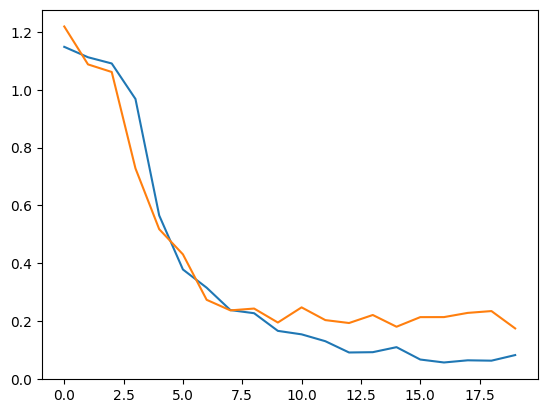

In [15]:
plt.plot(results['train_loss'])
plt.plot(results['test_loss'])

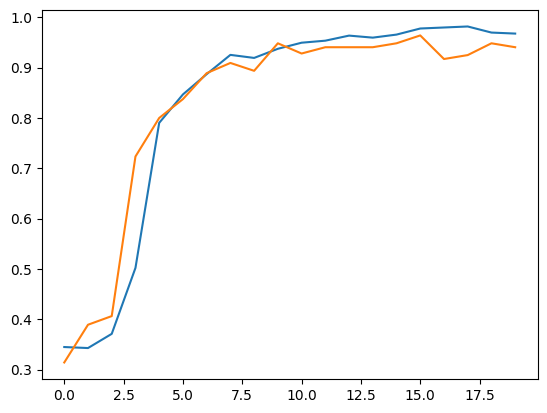

In [16]:
plt.plot(results['train_acc'])
plt.plot(results['test_acc'])

# Make Prediction

In [52]:
audio_file = os.path.join(root, 'cat',os.listdir(os.path.join(root, 'cat'))[100])

In [65]:
audio_actual , label_actual= test_data[100][0], test_data[100][1]

In [53]:
def preprocess( audio_file):
    # load the audio in wave form
    waveform_audio, sample_rate = librosa.load(audio_file)

    # Convert image to spectogram short time fourier transform
    waveform_audio_stft = librosa.stft(waveform_audio)

    # Convert image to amplitude_db form
    s_db = librosa.amplitude_to_db(np.abs(waveform_audio_stft), ref=np.max )

    # Convert to tensor
    s_db = torch.tensor(s_db).unsqueeze(0)

    # Resize 
    transform = transforms.Resize((1025,44), antialias=False)
    s_db = transform(s_db)

    # Reuturn image form of audio
    return s_db

In [54]:
audio = preprocess(audio_file)

In [66]:
index = torch.argmax(torch.softmax(model(audio_actual.unsqueeze(dim=0).to(device)), dim=1)).item()

In [67]:
labels[index]

'cat'

In [68]:
index==label_actual

True

In [17]:
from pathlib import Path
def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):
    # Create target directory
    target_dir_path = Path(target_dir)
    target_dir_path.mkdir(parents=True,
                        exist_ok=True)

    # Create model save path
    assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
    model_save_path = target_dir_path / model_name

    # Save the model state_dict()
    print(f"[INFO] Saving model to: {model_save_path}")
    torch.save(obj=model.state_dict(),
             f=model_save_path)

In [18]:
save_model(model, '', 'voice-classification-2.pth')

[INFO] Saving model to: voice-classification-2.pth


In [19]:
from tqdm.auto import tqdm
def test_model(model, device, test_dataloader):

    # Make predictions on the entire test dataset
    test_preds = []
    model = model.to(device)
    model.eval()
    
    with torch.inference_mode():
      # Loop through the batches in the test dataloader
      for X, y in tqdm(test_dataloader):
        X, y = X.to(device), y.to(device)
        # Pass the data through the model
        test_logits = model(X)

        # Convert the pred logits to pred probs
        pred_probs = torch.softmax(test_logits, dim=1)

        # Convert the pred probs into pred labels
        pred_labels = torch.argmax(pred_probs, dim=1)

        # Add the pred labels to test preds list
        test_preds.append(pred_labels)

    # Concatenate the test preds and put them on the CPU
    test_preds = torch.cat(test_preds).cpu()
    return test_preds

In [7]:
# Test the model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
load_model = DCNN(0.25).to(device)
load_model.load_state_dict(torch.load('../models/voice-classification-2.pth', map_location=torch.device('cpu')))

test_preds = test_model(load_model, device, test_loader)

<All keys matched successfully>

(array([-1.21706762e-07, -1.56127808e-05,  1.57127670e-06, ...,
        -1.74726956e-02, -1.34147685e-02, -1.10104037e-02], dtype=float32),
 22050)

In [22]:
test_truth = torch.cat([y for X, y in test_loader])
test_truth
print(len(test_preds))
print(len(test_truth))
print(test_preds.shape, test_truth.shape)

122
122
torch.Size([122]) torch.Size([122])


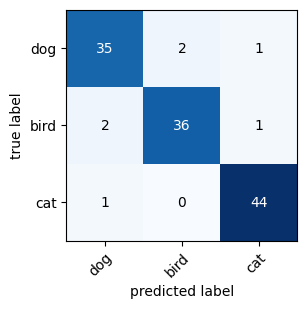

In [24]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
class_name = [i.split('/')[-1] for i in labels]
# Setup confusion matrix instance
confmat = ConfusionMatrix(num_classes=len(class_name) ,task="multiclass")
confmat_tensor = confmat(preds=test_preds,
                         target=test_truth)

# Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
    class_names=class_name,
    figsize=(4, 3)
)

# Kfold cross Validation

In [71]:
n_split = 5
kf = KFold(n_splits=n_split, shuffle=True)
fold_results = []

for fold, (train_indices, val_indices) in enumerate(kf.split(dataset)):
    print(f"Running fold  {fold+1}/{n_split}")
    train_ds = torch.utils.data.Subset(dataset, train_indices)
    val_ds = torch.utils.data.Subset(dataset, val_indices)
    
    train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=16, shuffle=False)
    
    model = DCNN(0.25).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=4e-4)
    loss_fn = nn.CrossEntropyLoss()
    results = train(model, train_loader, val_loader, optimizer, loss_fn, 14, device )
    
    fold_results.append(results)
    
   

Running fold  1/5


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 1 ===>  Train_loss 1.1240 ===>  Train_acc 0.3609 ===>  Test_loss 1.1115 ===>  Test_acc 0.3516


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 2 ===>  Train_loss 1.1080 ===>  Train_acc 0.3105 ===>  Test_loss 1.1027 ===>  Test_acc 0.3047


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 3 ===>  Train_loss 1.1058 ===>  Train_acc 0.3407 ===>  Test_loss 1.0968 ===>  Test_acc 0.3516


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 4 ===>  Train_loss 1.1005 ===>  Train_acc 0.3448 ===>  Test_loss 1.0964 ===>  Test_acc 0.3516


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 5 ===>  Train_loss 1.1023 ===>  Train_acc 0.3407 ===>  Test_loss 1.0974 ===>  Test_acc 0.3438


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 6 ===>  Train_loss 1.0972 ===>  Train_acc 0.3468 ===>  Test_loss 1.0907 ===>  Test_acc 0.4938


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 7 ===>  Train_loss 1.0497 ===>  Train_acc 0.4778 ===>  Test_loss 0.7601 ===>  Test_acc 0.6953


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 8 ===>  Train_loss 0.7019 ===>  Train_acc 0.7379 ===>  Test_loss 0.7534 ===>  Test_acc 0.7094


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 9 ===>  Train_loss 0.6013 ===>  Train_acc 0.7641 ===>  Test_loss 0.2399 ===>  Test_acc 0.9328


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 10 ===>  Train_loss 0.4561 ===>  Train_acc 0.8468 ===>  Test_loss 0.2554 ===>  Test_acc 0.9094


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 11 ===>  Train_loss 0.3210 ===>  Train_acc 0.8972 ===>  Test_loss 0.1526 ===>  Test_acc 0.9563


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 12 ===>  Train_loss 0.2692 ===>  Train_acc 0.9274 ===>  Test_loss 0.1121 ===>  Test_acc 0.9688


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 13 ===>  Train_loss 0.2357 ===>  Train_acc 0.9173 ===>  Test_loss 0.0761 ===>  Test_acc 0.9766


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 14 ===>  Train_loss 0.1810 ===>  Train_acc 0.9415 ===>  Test_loss 0.0561 ===>  Test_acc 0.9844
Running fold  2/5


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 1 ===>  Train_loss 1.1142 ===>  Train_acc 0.3569 ===>  Test_loss 1.1274 ===>  Test_acc 0.3453


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 2 ===>  Train_loss 1.1129 ===>  Train_acc 0.3065 ===>  Test_loss 1.0964 ===>  Test_acc 0.3359


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 3 ===>  Train_loss 1.0987 ===>  Train_acc 0.3407 ===>  Test_loss 1.0966 ===>  Test_acc 0.3047


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 4 ===>  Train_loss 1.0906 ===>  Train_acc 0.3871 ===>  Test_loss 1.0439 ===>  Test_acc 0.6625


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 5 ===>  Train_loss 0.7856 ===>  Train_acc 0.6734 ===>  Test_loss 0.4885 ===>  Test_acc 0.7594


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 6 ===>  Train_loss 0.4666 ===>  Train_acc 0.8246 ===>  Test_loss 0.4554 ===>  Test_acc 0.8266


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 7 ===>  Train_loss 0.3664 ===>  Train_acc 0.8589 ===>  Test_loss 0.2816 ===>  Test_acc 0.9172


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 8 ===>  Train_loss 0.2747 ===>  Train_acc 0.9173 ===>  Test_loss 0.2649 ===>  Test_acc 0.9172


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 9 ===>  Train_loss 0.2067 ===>  Train_acc 0.9194 ===>  Test_loss 0.2108 ===>  Test_acc 0.9375


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 10 ===>  Train_loss 0.1589 ===>  Train_acc 0.9335 ===>  Test_loss 0.1900 ===>  Test_acc 0.9250


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 11 ===>  Train_loss 0.1765 ===>  Train_acc 0.9435 ===>  Test_loss 0.1991 ===>  Test_acc 0.9375


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 12 ===>  Train_loss 0.1504 ===>  Train_acc 0.9556 ===>  Test_loss 0.1822 ===>  Test_acc 0.9250


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 13 ===>  Train_loss 0.1542 ===>  Train_acc 0.9456 ===>  Test_loss 0.2722 ===>  Test_acc 0.9219


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 14 ===>  Train_loss 0.0844 ===>  Train_acc 0.9637 ===>  Test_loss 0.1600 ===>  Test_acc 0.9453
Running fold  3/5


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 1 ===>  Train_loss 1.1784 ===>  Train_acc 0.3206 ===>  Test_loss 1.1114 ===>  Test_acc 0.3359


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 2 ===>  Train_loss 1.1077 ===>  Train_acc 0.3266 ===>  Test_loss 1.0975 ===>  Test_acc 0.3359


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 3 ===>  Train_loss 1.1004 ===>  Train_acc 0.3488 ===>  Test_loss 1.0953 ===>  Test_acc 0.3750


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 4 ===>  Train_loss 1.0993 ===>  Train_acc 0.3448 ===>  Test_loss 1.0805 ===>  Test_acc 0.4141


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 5 ===>  Train_loss 1.1035 ===>  Train_acc 0.3024 ===>  Test_loss 1.1003 ===>  Test_acc 0.3359


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 6 ===>  Train_loss 1.1007 ===>  Train_acc 0.3145 ===>  Test_loss 1.0977 ===>  Test_acc 0.3359


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 7 ===>  Train_loss 1.0984 ===>  Train_acc 0.3387 ===>  Test_loss 1.1003 ===>  Test_acc 0.3359


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 8 ===>  Train_loss 1.1053 ===>  Train_acc 0.3448 ===>  Test_loss 1.0822 ===>  Test_acc 0.4578


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 9 ===>  Train_loss 1.0789 ===>  Train_acc 0.3871 ===>  Test_loss 1.0004 ===>  Test_acc 0.4141


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 10 ===>  Train_loss 0.8319 ===>  Train_acc 0.6250 ===>  Test_loss 0.5210 ===>  Test_acc 0.8094


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 11 ===>  Train_loss 0.6090 ===>  Train_acc 0.7742 ===>  Test_loss 0.5192 ===>  Test_acc 0.8063


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 12 ===>  Train_loss 0.4818 ===>  Train_acc 0.8306 ===>  Test_loss 0.3803 ===>  Test_acc 0.8547


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 13 ===>  Train_loss 0.3357 ===>  Train_acc 0.8972 ===>  Test_loss 0.3447 ===>  Test_acc 0.9094


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 14 ===>  Train_loss 0.2788 ===>  Train_acc 0.9032 ===>  Test_loss 0.3104 ===>  Test_acc 0.8844
Running fold  4/5


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 1 ===>  Train_loss 1.2037 ===>  Train_acc 0.3468 ===>  Test_loss 1.1034 ===>  Test_acc 0.3125


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 2 ===>  Train_loss 1.0994 ===>  Train_acc 0.3347 ===>  Test_loss 1.1046 ===>  Test_acc 0.3125


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 3 ===>  Train_loss 1.1006 ===>  Train_acc 0.3488 ===>  Test_loss 1.1018 ===>  Test_acc 0.3125


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 4 ===>  Train_loss 1.0980 ===>  Train_acc 0.3468 ===>  Test_loss 1.1006 ===>  Test_acc 0.3125


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 5 ===>  Train_loss 1.0996 ===>  Train_acc 0.3085 ===>  Test_loss 1.0987 ===>  Test_acc 0.3422


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 6 ===>  Train_loss 1.0975 ===>  Train_acc 0.3730 ===>  Test_loss 1.1007 ===>  Test_acc 0.3125


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 7 ===>  Train_loss 1.0996 ===>  Train_acc 0.3105 ===>  Test_loss 1.1015 ===>  Test_acc 0.3125


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 8 ===>  Train_loss 1.0984 ===>  Train_acc 0.3528 ===>  Test_loss 1.0995 ===>  Test_acc 0.3125


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 9 ===>  Train_loss 1.0990 ===>  Train_acc 0.3387 ===>  Test_loss 1.0995 ===>  Test_acc 0.3125


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 10 ===>  Train_loss 1.0985 ===>  Train_acc 0.3528 ===>  Test_loss 1.0992 ===>  Test_acc 0.3125


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 11 ===>  Train_loss 1.0979 ===>  Train_acc 0.3266 ===>  Test_loss 1.0992 ===>  Test_acc 0.3594


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 12 ===>  Train_loss 1.0990 ===>  Train_acc 0.3427 ===>  Test_loss 1.1009 ===>  Test_acc 0.3125


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 13 ===>  Train_loss 1.0985 ===>  Train_acc 0.3286 ===>  Test_loss 1.0988 ===>  Test_acc 0.3391


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 14 ===>  Train_loss 1.1003 ===>  Train_acc 0.3367 ===>  Test_loss 1.1000 ===>  Test_acc 0.3125
Running fold  5/5


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 1 ===>  Train_loss 1.1383 ===>  Train_acc 0.3185 ===>  Test_loss 1.1046 ===>  Test_acc 0.2969


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 2 ===>  Train_loss 1.1100 ===>  Train_acc 0.3367 ===>  Test_loss 1.0945 ===>  Test_acc 0.4359


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 3 ===>  Train_loss 1.1061 ===>  Train_acc 0.3367 ===>  Test_loss 1.0966 ===>  Test_acc 0.3594


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 4 ===>  Train_loss 1.1040 ===>  Train_acc 0.3266 ===>  Test_loss 1.0959 ===>  Test_acc 0.3656


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 5 ===>  Train_loss 1.0848 ===>  Train_acc 0.4093 ===>  Test_loss 1.0592 ===>  Test_acc 0.5687


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 6 ===>  Train_loss 0.9651 ===>  Train_acc 0.5202 ===>  Test_loss 0.6677 ===>  Test_acc 0.7703


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 7 ===>  Train_loss 0.5248 ===>  Train_acc 0.7883 ===>  Test_loss 0.7795 ===>  Test_acc 0.6234


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 8 ===>  Train_loss 0.3489 ===>  Train_acc 0.8609 ===>  Test_loss 0.4288 ===>  Test_acc 0.8703


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 9 ===>  Train_loss 0.2144 ===>  Train_acc 0.9073 ===>  Test_loss 0.3576 ===>  Test_acc 0.8906


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 10 ===>  Train_loss 0.1690 ===>  Train_acc 0.9435 ===>  Test_loss 0.4366 ===>  Test_acc 0.8703


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 11 ===>  Train_loss 0.1677 ===>  Train_acc 0.9335 ===>  Test_loss 0.4011 ===>  Test_acc 0.9141


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 12 ===>  Train_loss 0.1192 ===>  Train_acc 0.9516 ===>  Test_loss 0.3272 ===>  Test_acc 0.9062


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 13 ===>  Train_loss 0.1053 ===>  Train_acc 0.9597 ===>  Test_loss 0.3472 ===>  Test_acc 0.9062


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 14 ===>  Train_loss 0.0900 ===>  Train_acc 0.9718 ===>  Test_loss 0.3042 ===>  Test_acc 0.8984


In [81]:
fold_train_loss = []
fold_test_loss = []
fold_train_acc = []
fold_test_acc = []
for i in range(len(fold_results)):
    fold_train_loss.append(min(fold_results[i]['train_loss']))
    fold_test_loss.append(min(fold_results[i]['test_loss']))
    fold_train_acc.append(max(fold_results[i]['train_acc']))
    fold_test_acc.append(max(fold_results[i]['test_acc']))

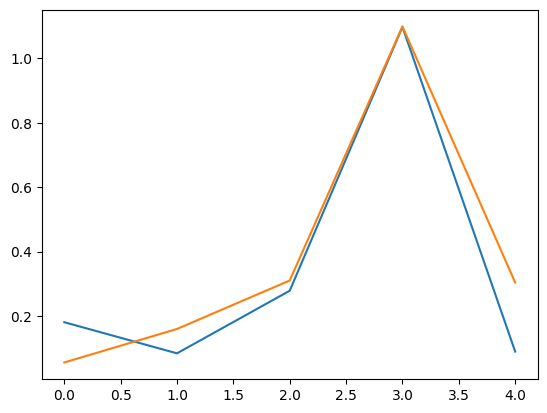

In [84]:
plt.plot(fold_train_loss)
plt.plot(fold_test_loss)

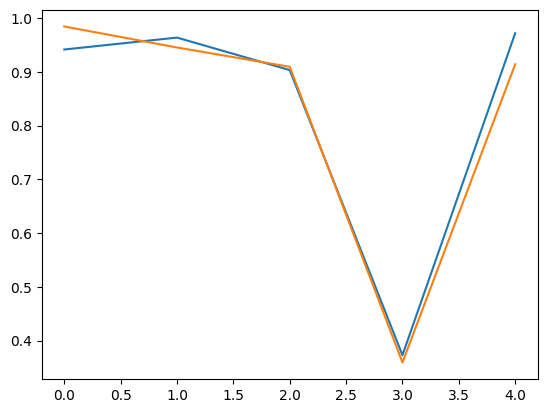

In [85]:
plt.plot(fold_train_acc)
plt.plot(fold_test_acc)

In [91]:
min_train_loss, fold = min(fold_train_loss), fold_train_loss.index(min(fold_train_loss))
print(f"Minimumn fold train loss {min_train_loss}, fold number {fold}" )

min_test_loss, fold = min(fold_test_loss), fold_test_loss.index(min(fold_test_loss))
print(f"Minimumn fold test loss {min_test_loss}, fold number {fold}" )

max_train_acc, fold = max(fold_train_acc), fold_train_acc.index(max(fold_train_acc))
print(f"Maximum fold train acc {max_train_acc}, fold number {fold}" )

max_test_acc, fold = max(fold_test_acc), fold_test_acc.index(max(fold_test_acc))
print(f"Maximum fold train acc {max_test_acc}, fold number {fold}" )


Minimumn fold train loss 0.08442379990893026, fold number 1
Minimumn fold test loss 0.05606847256422043, fold number 0
Maximum fold train acc 0.9717741935483871, fold number 4
Maximum fold train acc 0.984375, fold number 0


In [92]:
print(min(fold_train_acc), max(fold_train_acc))
print(min(fold_test_acc), max(fold_test_acc))

0.37298387096774194 0.9717741935483871
0.359375 0.984375


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import optuna

def objective(trial):
    # Define hyperparameters to optimize
    dropout = trial.suggest_float("dropout", 0.2, 0.5)
    lr = trial.suggest_float("lr", 1e-5, 1e-3)
    batch_size = trial.suggest_categorical("batch_size", [16, 32])

    # Define the model, loss function and optimizer
    model = DCNN(dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Define data loaders
    dataset_len = len(dataset)
    train_size = int(0.8 * dataset_len)
    test_size = dataset_len - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Train and evaluate the model for `num_epochs` epochs
    for epoch in range(num_epochs):
        model.train()
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            accuracy = 100 * correct / total
            trial.report(accuracy, epoch)
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()

    return accuracy

In [8]:
# Define constants
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 15

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, n_jobs=1)
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-05-09 07:41:57,120] A new study created in memory with name: no-name-d773dc2d-6e42-4a45-8c96-fff5283f3997
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[I 2023-05-09 07:42:58,109] Trial 0 finished with value: 89.34426229508196 and parameters: {'dropout': 0.3038317942107731, 'lr': 0.0002648005373140072, 'batch_size': 32}. Best is trial 0 with value: 89.34426229508196.
[I 2023-05-09 07:43:39,447] Trial 1 finished with value: 91.80327868852459 and parameters: {'dropout': 0.29060428209214295, 'lr': 0.0003333969554639653, 'batch_size': 32}. Best is trial 1 with value: 91.80327868852459.
[I 2023-05-09 07:44:20,151] Trial 2 finished with value: 34.42622950819672 and parameters: {'dropout': 0.2116724104058225, 'lr': 0.0005332056779937874, 'batch_size': 16}. Best is trial 1 with value: 

Best trial:
  Value:  96.72131147540983
  Params: 
    dropout: 0.39900507067172
    lr: 0.0006673383634151085
    batch_size: 16


In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [13]:
trial.params


{'dropout': 0.39900507067172, 'lr': 0.0006673383634151085, 'batch_size': 16}